In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Analysing Model Capacity

The issues associated with validation and 
cross-validation are some of the most important
aspects of the practice of machine learning.  

Selecting the optimal model for your data is vital, and is a piece of the problem that is not often
appreciated by machine learning practitioners.

Of core importance is the following question:

**If our estimator is underperforming, how should we move forward?**

- Use simpler or more complicated model?
- Add more features to each observed data point?
- Add more training samples?

The answer is often counter-intuitive.  

In particular, **sometimes using a
more complicated model will give _worse_ results.**  

Also, **sometimes adding
training data will not improve your results.**  

The ability to determine
what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

## Learning Curves and Validation Curves

One way to address this issue is to use what are often called **Learning Curves**.
Given a particular dataset and a model we'd like to fit (e.g. using feature creation and linear regression), we'd
like to tune our value of the *hyperparameter* ``kernel`` to give us the best fit. We can visualize the different regimes with the following plot, modified from the sklearn examples [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)


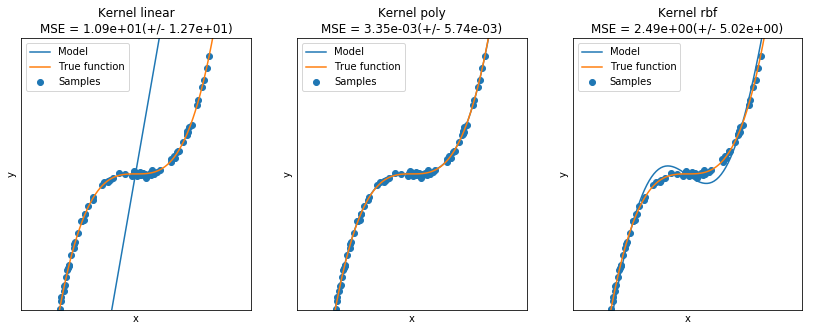

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn import model_selection

rng = np.random.RandomState(42)

n_samples = 200
kernels = ['linear', 'poly', 'rbf']

true_fun = lambda X: X ** 3
X = np.sort(5 * (rng.rand(n_samples) - .5))
y = true_fun(X) + .01 * rng.randn(n_samples)

plt.figure(figsize=(14, 5))
for i in range(len(kernels)):
    ax = plt.subplot(1, len(kernels), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    model = SVR(kernel=kernels[i], C=5, gamma='auto')
    model.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = model_selection.cross_val_score(model,
        X[:, np.newaxis], y, scoring='neg_mean_squared_error', cv=10)

    X_test = np.linspace(3 * -.5, 3 * .5, 100)
    plt.plot(X_test, model.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((-3 * .5, 3 * .5))
    plt.ylim((-1, 1))
    plt.legend(loc="best")
    plt.title("Kernel {}\nMSE = {:.2e}(+/- {:.2e})".format(
        kernels[i], -scores.mean(), scores.std()))
plt.show()

Learning Curves
============

What the right model for a dataset is depends critically on how much data we have. More data allows us to be more confident about building a complex model. Lets built some intuition on why that is. Look at the following datasets:


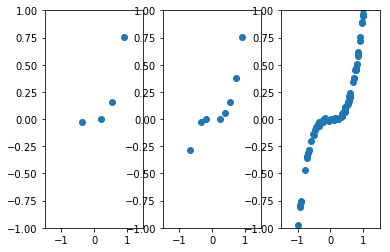

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection as cross_validation

rng = np.random.RandomState(0)
n_samples = 200

true_fun = lambda X: X ** 3
X = np.sort(5 * (rng.rand(n_samples) - .5))
y = true_fun(X) + .01 * rng.randn(n_samples)
X = X[:, None]
y = y
f, axarr = plt.subplots(1, 3)
axarr[0].scatter(X[::20], y[::20])
axarr[0].set_xlim((-3 * .5, 3 * .5))
axarr[0].set_ylim((-1, 1))
axarr[1].scatter(X[::10], y[::10])
axarr[1].set_xlim((-3 * .5, 3 * .5))
axarr[1].set_ylim((-1, 1))
axarr[2].scatter(X, y)
axarr[2].set_xlim((-3 * .5, 3 * .5))
axarr[2].set_ylim((-1, 1))
plt.show()

They all come from the same underlying process. But if you were asked to make a prediction, you would be more likely to draw a straight line for the left-most one, as there are only very few datapoints, and no real rule is apparent. For the dataset in the middle, some structure is recognizable, though the exact shape of the true function is maybe not obvious. With even more data on the right hand side, you would probably be very comfortable with drawing a curved line with a lot of certainty.

A great way to explore how a model fit evolves with different dataset sizes are learning curves.
A learning curve plots the validation error for a given model against different training set sizes.

But first, take a moment to think about what we're going to see:

**Questions:**

- **As the number of training samples are increased, what do you expect to see for the training error?  For the validation error?**
- **Would you expect the training error to be higher or lower than the validation error?  Would you ever expect this to change?**

We can run the following code to plot the learning curve for a ``kernel = linear`` model:

[-5.32514533 -5.85866065 -5.4357387  -4.80991855 -6.33920203]


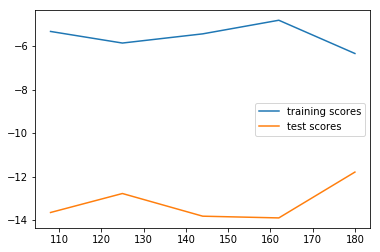

In [23]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR
# This is actually negative MSE!
training_sizes, train_scores, test_scores = learning_curve(SVR(kernel='linear'), X, y, cv=10,
                                                           scoring="neg_mean_squared_error",
                                                           train_sizes=[.6, .7, .8, .9, 1.])
# Use the negative because we want to maximize score
print(train_scores.mean(axis=1))
plt.plot(training_sizes, train_scores.mean(axis=1), label="training scores")
plt.plot(training_sizes, test_scores.mean(axis=1), label="test scores")
#plt.ylim((0, 50))
plt.legend(loc='best')

You can see that for the model with ``kernel = linear``, the validation score doesn't really improve as more data is given.

Notice that the validation error *generally improves* with a growing training set,
while the training error *generally gets worse* with a growing training set.  From
this we can infer that as the training size increases, they will converge to a single
value.

From the above discussion, we know that `kernel = linear`
underfits the data. This is indicated by the fact that both the
training and validation errors are very poor. When confronted with this type of learning curve,
we can expect that adding more training data will not help matters: both
lines will converge to a relatively high error.

**When the learning curves have converged to a poor error, we have an underfitting model.**

An underfitting model can be improved by:

- Using a more sophisticated model (i.e. in this case, increase complexity of the ``kernel`` parameter)
- Gather more features for each sample.
- Decrease regularization in a regularized model.

A underfitting model cannot be improved, however, by increasing the number of training
samples (do you see why?)

Now let's look at an overfit model:

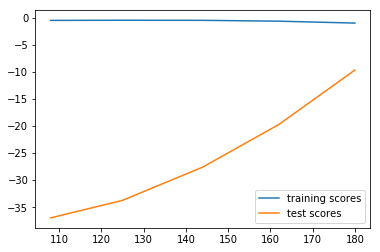

In [26]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR
training_sizes, train_scores, test_scores = learning_curve(SVR(kernel='rbf', gamma='auto'), X, y, cv=10,
                                                           scoring="neg_mean_squared_error",
                                                           train_sizes=[.6, .7, .8, .9, 1.])
# Use the negative because we want to minimize squared error
plt.plot(training_sizes, train_scores.mean(axis=1), label="training scores")
plt.plot(training_sizes, test_scores.mean(axis=1), label="test scores")
plt.legend(loc='best')
plt.show()


Here we show the learning curve for `kernel = rbf`. From the above
discussion, we know that `kernel = rbf` is an estimator
which mildly **overfits** the data. This is indicated by the fact that the
training error is **much** better than the validation error. As
we add more samples to this training set, the training error will
continue to worsen, while the cross-validation error will continue
to improve, until they meet in the middle. We can infer that adding more
data will allow the estimator to very closely match the best
possible cross-validation error.

**When the learning curves have not yet converged with our full training set, it indicates an overfit model.**

An overfitting model can be improved by:

- Gathering more training samples.
- Using a less-sophisticated model (i.e. in this case, make ``kernel`` less complex with ``kernel = poly``)
- Increasing regularization (parameter ``C`` for SVM/SVR).

In particular, gathering more features for each sample will not help the results.

## Summary

We’ve seen above that an under-performing algorithm can be due
to two possible situations: underfitting and overfitting.
Using the technique of learning curves, we can train on progressively
larger subsets of the data, evaluating the training error and
cross-validation error to determine whether our algorithm is overfitting or underfitting. But what do we do with this information?

### Underfitting

If our algorithm is **underfitting**, the following actions might help:

- **Add more features**. It may be helpful to make use of information as 
  additional features. For example, to predict housing prices
  features such as the neighborhood
  the house is in, the year the house was built, the size of the lot, etc.
  can help the model by giving new dimensions to help differentiate
  houses. Adding these features to the training and test sets can improve
  the fit.
- **Use a more sophisticated model**. Adding complexity to the model can
  help improve the fit. For a SVR fit, this can be accomplished
  by increasing the kernel complexity (generally ``linear`` << ``poly`` << ``rbf``).
  Each learning technique has its own methods of adding complexity.

- **Use fewer samples**. Though this will not improve the classification,
  an underfitting algorithm can attain nearly the same error with a smaller
  training sample. For algorithms which are computationally expensive,
  reducing the training sample size can lead to very large improvements
  in speed.
- **Decrease regularization**. Regularization is a technique used to impose
  simplicity in some machine learning models, by adding a penalty term that
  depends on the characteristics of the parameters. If a model is underfitting,
  decreasing the regularization can lead to better results.

### Overfitting

If our algorithm shows signs of **overfitting**, the following actions might help:

- **Use fewer features**. Using a feature selection technique may be
  useful, and decrease the overfitting of the estimator.
- **Use a simpler model**.  Model complexity and overfitting go hand-in-hand.
   For example, models like random forests tend to overfit
   much more than linear models and SVMs.
- **Use more training samples**. Adding training samples can reduce
  the effect of overfitting.
- **Increase Regularization**. Regularization is designed to prevent
  overfitting. So increasing regularization
  can lead to better results for overfitting models.

These choices become very important in real-world situations, as data collection usually
costs time and energy. 

If the model is underfitting, then spending weeks or months collecting
more data could be a colossal waste of time! 

However, more data (usually) gives us a better view
of the true nature of the problem, so these issues should always be carefully considered before
going on a "data foraging expedition".